<a href="https://colab.research.google.com/github/atryt0ne/cs690-multimodal-integration/blob/main/code/teaseq_scmodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TEA-Seq scMODAL
- Demonstrates the capacity of scMODAL to handle trimodal data
- Original data is available at [GEO PBMC TEA-seq](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158013)

In [ ]:
!git clone https://github.com/gefeiwang/scMODAL.git

Cloning into 'scMODAL'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 57 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 1.18 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!cp -r scMODAL/scmodal scmodal

In [ ]:
!pip install anndata scanpy numba umap-learn torch annoy gdown scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 14.4 MB/s eta 0:00:00


In [ ]:
!gdown 1B3z7bpF8elqpjBasruY1vGfdx1FgPVpv
!gdown 1XoPFBlvSGL5o_J3gh380_ImiJEl5jYt3
!gdown 1syYYdA4c3JxTnc9QK1SSwXgKgNDn9l3E
!gdown 1ja8aXvTFcASyvNRDCosmXyXQaRG9XvmU

Downloading...
From: https://drive.google.com/uc?id=1B3z7bpF8elqpjBasruY1vGfdx1FgPVpv
To: /content/ADT.h5ad
100% 5.69M/5.69M [00:00<00:00, 24.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XoPFBlvSGL5o_J3gh380_ImiJEl5jYt3
From (redirected): https://drive.google.com/uc?id=1XoPFBlvSGL5o_J3gh380_ImiJEl5jYt3&confirm=t&uuid=1ebda277-bec3-4245-bff9-0afa119207b8
To: /content/ATAC.h5ad
100% 432M/432M [00:09<00:00, 44.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1syYYdA4c3JxTnc9QK1SSwXgKgNDn9l3E
To: /content/RNA.h5ad
100% 71.9M/71.9M [00:01<00:00, 50.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ja8aXvTFcASyvNRDCosmXyXQaRG9XvmU
To: /content/protein_gene_conversion.csv
100% 4.96k/4.96k [00:00<00:00, 15.9MB/s]


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os

import scmodal

import warnings
warnings.filterwarnings("ignore")

In [ ]:
adata_RNA = sc.read_h5ad('RNA.h5ad')
adata_ATAC = sc.read_h5ad('ATAC.h5ad')
adata_ADT = sc.read_h5ad('ADT.h5ad')

In [ ]:
adata_ATAC

AnnData object with n_obs × n_vars = 7437 × 1000
    obs: 'barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'celltype'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'feature_name'
    uns: 'hvg'

In [ ]:
correspondence = pd.read_csv('protein_gene_conversion.csv')
correspondence['Protein name'] = correspondence['Protein name'].replace(to_replace={'TCRab': 'TCR-a/b', 'TCRgd': 'TCR-g/d'})
print(correspondence)

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in adata_ADT.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in adata_RNA.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

      Protein name                   RNA name
0             CD80                       CD80
1             CD86                       CD86
2            CD274                      CD274
3            CD273                   PDCD1LG2
4            CD275                     ICOSLG
..             ...                        ...
336         HLA.DR  HLA-DRA/HLA-DRB1/HLA-DRB3
337  TCR.Va24.Ja18       Ignore: isoform skip
338      TCR.Va7.2       Ignore: isoform skip
339        TCR.a.b                    TRA/TRB
340        TCR.g.d                    TRG/TRD

[341 rows x 2 columns]


In [ ]:
RNA_shared = adata_RNA[:, rna_protein_correspondence[:, 0]].copy()
ADT_shared = adata_ADT[:, rna_protein_correspondence[:, 1]].copy()
RNA_shared.var['feature_name'] = RNA_shared.var.index.values
ADT_shared.var['feature_name'] = ADT_shared.var.index.values
RNA_shared.var_names_make_unique()
ADT_shared.var_names_make_unique()

RNA_unshared = adata_RNA[:, sorted(set(adata_RNA.var.index) - set(rna_protein_correspondence[:, 0]))].copy()
ADT_unshared = adata_ADT[:, sorted(set(adata_ADT.var.index) - set(rna_protein_correspondence[:, 1]))].copy()

sc.pp.highly_variable_genes(RNA_unshared, flavor='seurat_v3', n_top_genes=1000)
RNA_unshared = RNA_unshared[:, RNA_unshared.var.highly_variable].copy()

RNA_unshared.var['feature_name'] = RNA_unshared.var.index.values
ADT_unshared.var['feature_name'] = ADT_unshared.var.index.values

In [ ]:
RNA_counts = RNA_shared.X.sum(axis=1)
ADT_counts = ADT_shared.X.sum(axis=1)
target_sum = np.maximum(np.median(np.array(RNA_counts).copy()), 20)

sc.pp.normalize_total(RNA_shared, target_sum=target_sum)
sc.pp.log1p(RNA_shared)

sc.pp.normalize_total(ADT_shared, target_sum=target_sum)
sc.pp.log1p(ADT_shared)

sc.pp.normalize_total(RNA_unshared)
sc.pp.log1p(RNA_unshared)

sc.pp.normalize_total(ADT_unshared)
sc.pp.log1p(ADT_unshared)

adata1 = ad.concat([ADT_shared, ADT_unshared], axis=1)
adata2 = ad.concat([RNA_shared, RNA_unshared], axis=1)

sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)

sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)
adata_ATAC = adata_ATAC[:, adata_ATAC.var.highly_variable].copy()
adata_ATAC.var['feature_name'] = adata_ATAC.var.index.values

adata3 = adata_ATAC.copy()
sc.pp.normalize_total(adata3)
sc.pp.log1p(adata3)
sc.pp.scale(adata3, max_value=10)

In [ ]:
adata2

AnnData object with n_obs × n_vars = 7437 × 1046
    var: 'gene_ids', 'feature_types', 'genome', 'feature_name', 'mean', 'std'

In [ ]:
adata3

AnnData object with n_obs × n_vars = 7437 × 1000
    obs: 'barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'celltype'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'feature_name', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [ ]:
RNA_ATAC_shared = sorted(list(adata2.var.index.intersection(adata3.var.index)))

adata23_shared = ad.concat([adata2[:, RNA_ATAC_shared], adata3[:, RNA_ATAC_shared]])
sc.tl.pca(adata23_shared, n_comps=30)

In [ ]:
model = scmodal.model.Model(training_steps=12000, model_path="./TEA-seq_PBMC")

In [ ]:
model.integrate_datasets_feats(input_feats=[adata1.X, adata2.X, adata3.X],
                              paired_input_MNN=[[adata1.X[:, :RNA_shared.shape[1]], adata2.X[:, :RNA_shared.shape[1]]],
                                                [adata23_shared.obsm['X_pca'][:adata2.shape[0]], adata23_shared.obsm['X_pca'][adata2.shape[0]:]]])

Begining time:  Tue Nov 26 12:27:07 2024
step 0, loss_D=0.343221, loss_GAN=-0.194079, loss_AE=278.313232, loss_Geo=-11.916582, loss_LA=9018.402344, loss_MNN=70.051659
step 2000, loss_D=1.968632, loss_GAN=-1.898983, loss_AE=16.057053, loss_Geo=-29.137283, loss_LA=0.754501, loss_MNN=0.493195
step 4000, loss_D=2.363747, loss_GAN=-2.272770, loss_AE=15.046206, loss_Geo=-29.190779, loss_LA=0.604012, loss_MNN=0.324114
step 6000, loss_D=2.500910, loss_GAN=-2.453826, loss_AE=15.057707, loss_Geo=-29.202896, loss_LA=0.359571, loss_MNN=0.324316
step 8000, loss_D=2.628506, loss_GAN=-2.578486, loss_AE=15.057489, loss_Geo=-29.186138, loss_LA=0.414490, loss_MNN=0.330011
step 10000, loss_D=2.484193, loss_GAN=-2.441427, loss_AE=14.723913, loss_Geo=-29.215923, loss_LA=0.339786, loss_MNN=0.324491
step 12000, loss_D=2.541163, loss_GAN=-2.500926, loss_AE=14.797764, loss_Geo=-29.211657, loss_LA=0.274537, loss_MNN=0.313028
step 14000, loss_D=2.544517, loss_GAN=-2.496069, loss_AE=15.002068, loss_Geo=-29.206116

In [ ]:
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_ADT.obs, adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['ADT'] * adata_ADT.shape[0] + ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_RNA.shape[0]

scmodal.utils.compute_umap(adata_integrated)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_jobs=1, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Tue Nov 26 13:25:48 2024 Construct fuzzy simplicial set
Tue Nov 26 13:25:48 2024 Finding Nearest Neighbors
Tue Nov 26 13:25:48 2024 Building RP forest with 12 trees
Tue Nov 26 13:25:52 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Nov 26 13:26:15 2024 Finished Nearest Neighbor Search
Tue Nov 26 13:26:18 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 26 13:26:42 2024 Finished embedding


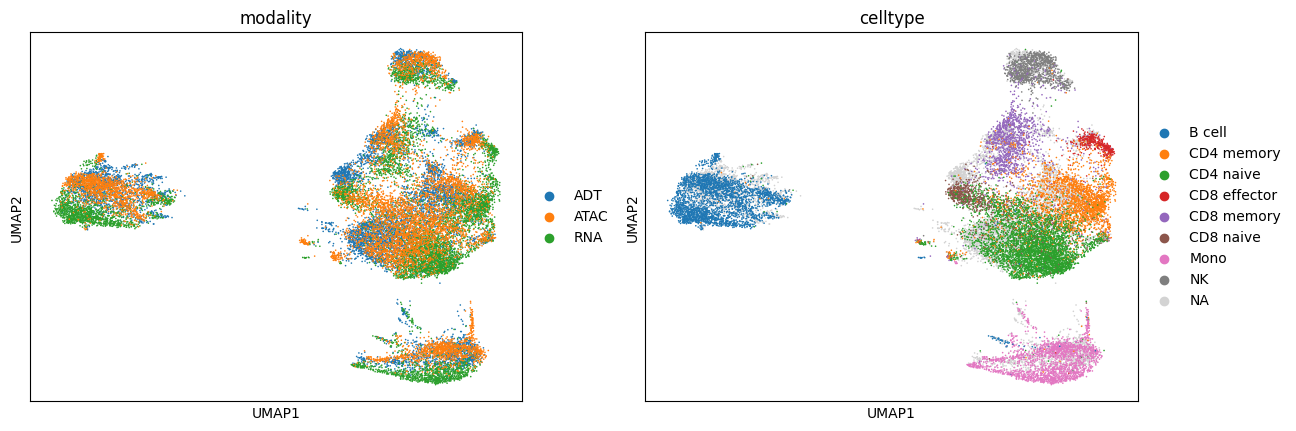

In [ ]:
sc.pl.umap(adata_integrated, color=['modality', 'celltype'])

In [ ]:
from scipy.spatial.distance import cdist

dist_mtx = cdist(model.latent[2*adata1.shape[0]:, :],
                 model.latent[:adata1.shape[0], :],
                 metric='euclidean') # Transfer labels from RNA to ATAC

matching = dist_mtx.argsort()[:, :1]

df1_labels = adata_RNA.obs["celltype"].values
df2_labels = adata_ATAC.obs["celltype"].values

print("Label transfer accuracy: ", np.sum(df1_labels == df2_labels[matching.reshape(-1)]) / adata_RNA.shape[0])

Label transfer accuracy:  0.809600645421541
